In [1]:
# ensure classes imported from .py files are dynamically updated
%load_ext autoreload
%autoreload 2

# plot matplots nicely
%matplotlib inline  

In [2]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import cmocean

# load pre-built data classes
from steric_height import StericHeight
from plotting_fns import PlottingFns as pfns
from utils import Utils as utls
from region import Region as rg
from data_handler import *


pfns = pfns()

In [3]:
#setup colours
c_altimetry = 'darkslategrey'#'teal'
c_dota = 'steelblue'
c_grace = 'mediumorchid'
c_altimetry_l = 'mediumaquamarine'
c_dota_l = 'lightblue'
c_grace_l = 'thistle'
c_profiles_l = 'mediumpurple'
c_profiles = 'rebeccapurple'
c_msla = 'orange'
c_msla_l = 'wheat'

In [4]:
dot_ds = DOT().ds
lwe_ds = GRACE().ds
msl_ds = ERA5().ds

sha = StericHeight(ssh_ref='DOT',
                   ssh=dot_ds.dot,
                   lwe=lwe_ds.lwe_thickness,
                   msl=msl_ds.msl
                  ).get_sha()

gpha = GPHA()

In [5]:
sta = dot_ds.time[0]
fin = dot_ds.time[-1]

In [6]:
# get hi res GEBCO
gebco_coarse = GEBCO(coarsen_factor=40).ds
gebco_fine = GEBCO(coarsen_factor=10).ds

In [7]:
profiles = gpha.profile_df
profiles_argo = profiles[profiles.float_type=='ARGO']
profiles_meop = profiles[profiles.float_type=='MEOP']
profiles_gridded = gpha.gridded_ds
sha_gph = xr.merge([sha,profiles_gridded])

In [9]:
sha_gph['profile_gpha'] = 100*(sha_gph.profile_gph - sha_gph.profile_gph.sel(time=slice(sta,fin)).mean('time'))

In [10]:
n_profiles = (~np.isnan(sha_gph.profile_gpha)).sum('time')
sha_corr = sha_gph.sha.where(n_profiles > 6, drop = True)
gph_corr = sha_gph.profile_gpha.where(n_profiles > 6, drop = True)

In [11]:
def timeseries_with_cmt(region):
    
    ds = region.crop_da(sha_gph)
    fig, axs = plt.subplots(5,2,figsize=(16,12),gridspec_kw={'width_ratios': [2,1]})

    data_monthly = ds.where(~np.isnan(ds.sha))
    data_monthly_mean = data_monthly.mean(['latitude','longitude'])
    
    # climatology
    cmt = data_monthly.groupby('time.month').mean('time',skipna=True)
    cmt_mean = cmt.mean(['latitude','longitude'])

    #
    def plot_monthly(ax,var,c,cl,ylabel,mkr='-'):
        ax.plot(data_monthly.time,data_monthly_mean[var].to_numpy(),mkr,c=c)
        ax.plot(data_monthly.time,data_monthly_mean[var].rolling(time=12,min_periods=6).mean(),'-',c=cl)
        ax.set_ylabel(ylabel)
        ax.grid()
        
    def plot_climatology(ax,var,c,cl,mkr='-'):
        for grp in data_monthly_mean.groupby('time.year'):
            data = grp[1].groupby('time.month').mean()
            ax.plot(data.month,data[var],mkr,label=grp[0],c=cl)
        ax.plot(cmt.month,cmt_mean[var].to_numpy(),'-',c=c)
        ax.set_xticks(np.arange(1,13))
        ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
        ax.set_xlim([0.5,12.5])
        ax.grid()
    
    plot_monthly(axs[0][0],'ssha',c_dota_l,c_dota,'DOTA')
    plot_monthly(axs[1][0],'eha',c_grace_l,c_grace,'EHA')
    plot_monthly(axs[2][0],'sha',c_msla_l,c_msla,'SHA W MSLPA')
    plot_monthly(axs[3][0],'sha_grace_only',c_altimetry_l,c_altimetry,'SHA')
    plot_monthly(axs[4][0],'profile_gpha',c_profiles_l,c_profiles,'GPHA')
    
    plot_climatology(axs[0][1],'ssha',c_dota,c_dota_l)
    plot_climatology(axs[1][1],'eha',c_grace,c_grace_l)
    plot_climatology(axs[2][1],'sha',c_msla,c_msla_l)
    plot_climatology(axs[3][1],'sha_grace_only',c_altimetry,c_altimetry_l)
    plot_climatology(axs[4][1],'profile_gpha',c_profiles,c_profiles_l)
    
    
    return fig, axs


<GeoAxes: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

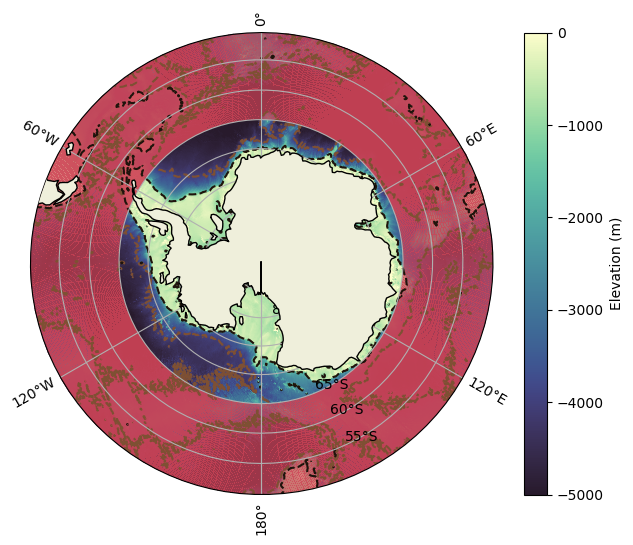

In [28]:
so = rg('Southern Oce',[-180,180,-65,-50],elevation=gebco_coarse.elevation)
so.plot_region()

(<Figure size 1600x1200 with 10 Axes>,
 array([[<Axes: ylabel='DOTA'>, <Axes: >],
        [<Axes: ylabel='EHA'>, <Axes: >],
        [<Axes: ylabel='MSLPA'>, <Axes: >],
        [<Axes: ylabel='SHA'>, <Axes: >],
        [<Axes: ylabel='GPHA'>, <Axes: >]], dtype=object))

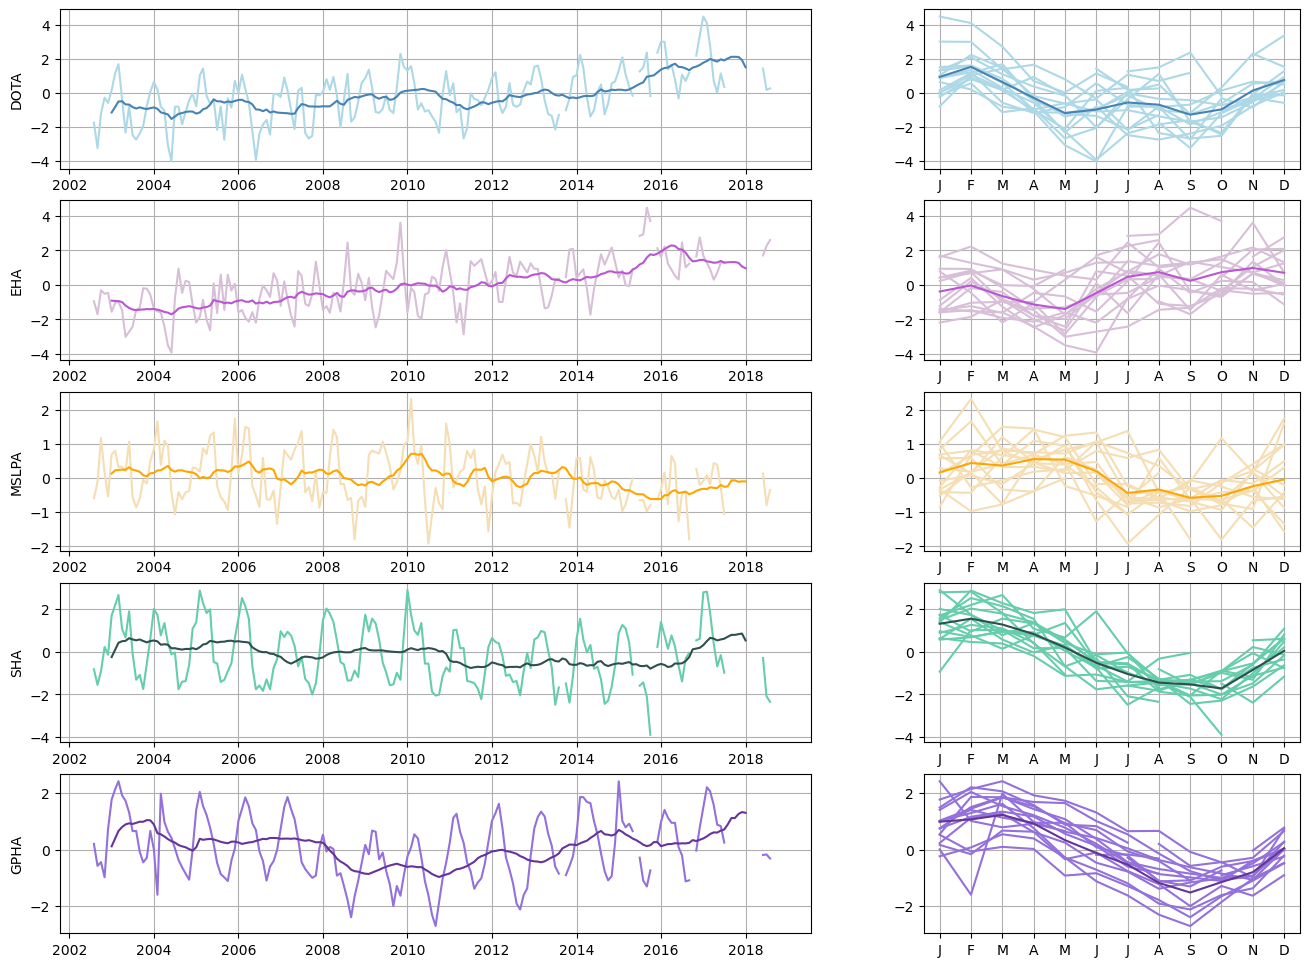

In [37]:
timeseries_with_cmt(so)

<GeoAxes: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

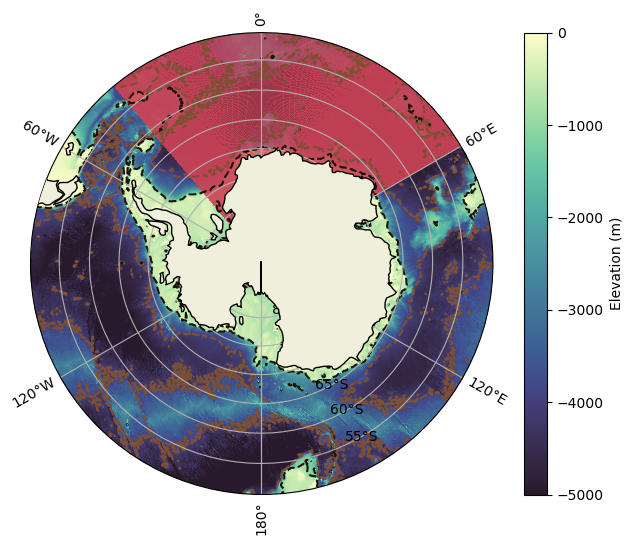

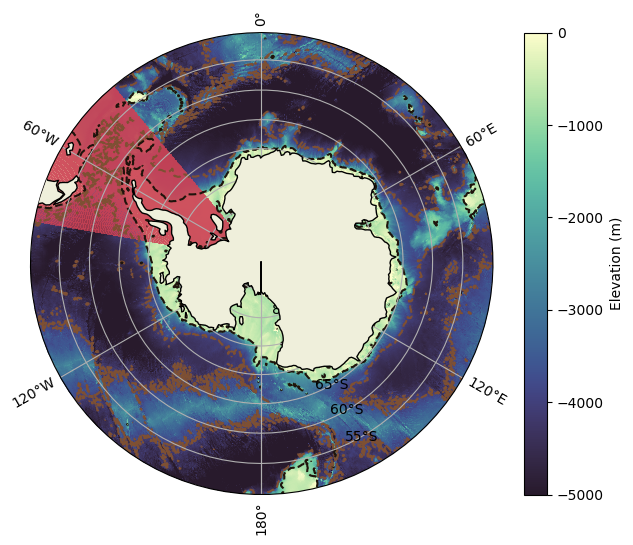

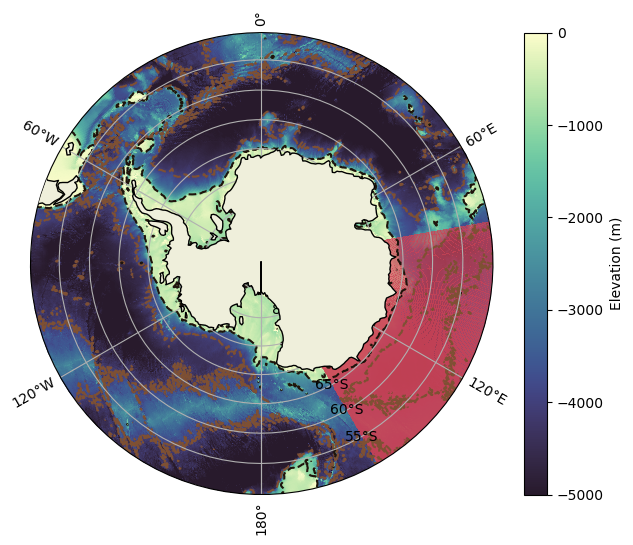

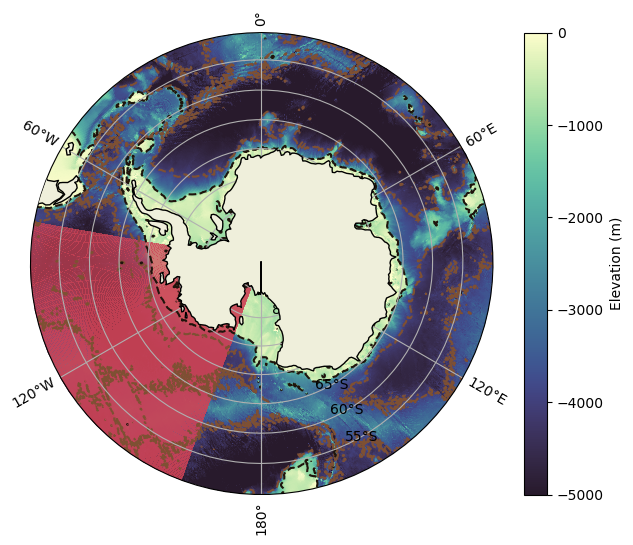

In [20]:
atlantic = rg('Indian-Atlantic Basin',[-40,60,-90,-50],elevation=gebco_coarse.elevation)
peninsula = rg('Indian Sector',[-80,-40,-90,-50],elevation=gebco_coarse.elevation)
australian = rg('Ausrtalian Sector',[80,150,-90,-50],elevation=gebco_coarse.elevation)
pacific = rg('Pacific Sector',[-160,-80,-90,-50],elevation=gebco_coarse.elevation)


atlantic.plot_region()
peninsula.plot_region()
australian.plot_region()
pacific.plot_region()

(<Figure size 1600x1000 with 8 Axes>,
 array([[<Axes: ylabel='DOTA'>, <Axes: >],
        [<Axes: ylabel='EHA'>, <Axes: >],
        [<Axes: ylabel='MSLPA'>, <Axes: >],
        [<Axes: ylabel='SHA'>, <Axes: >]], dtype=object))

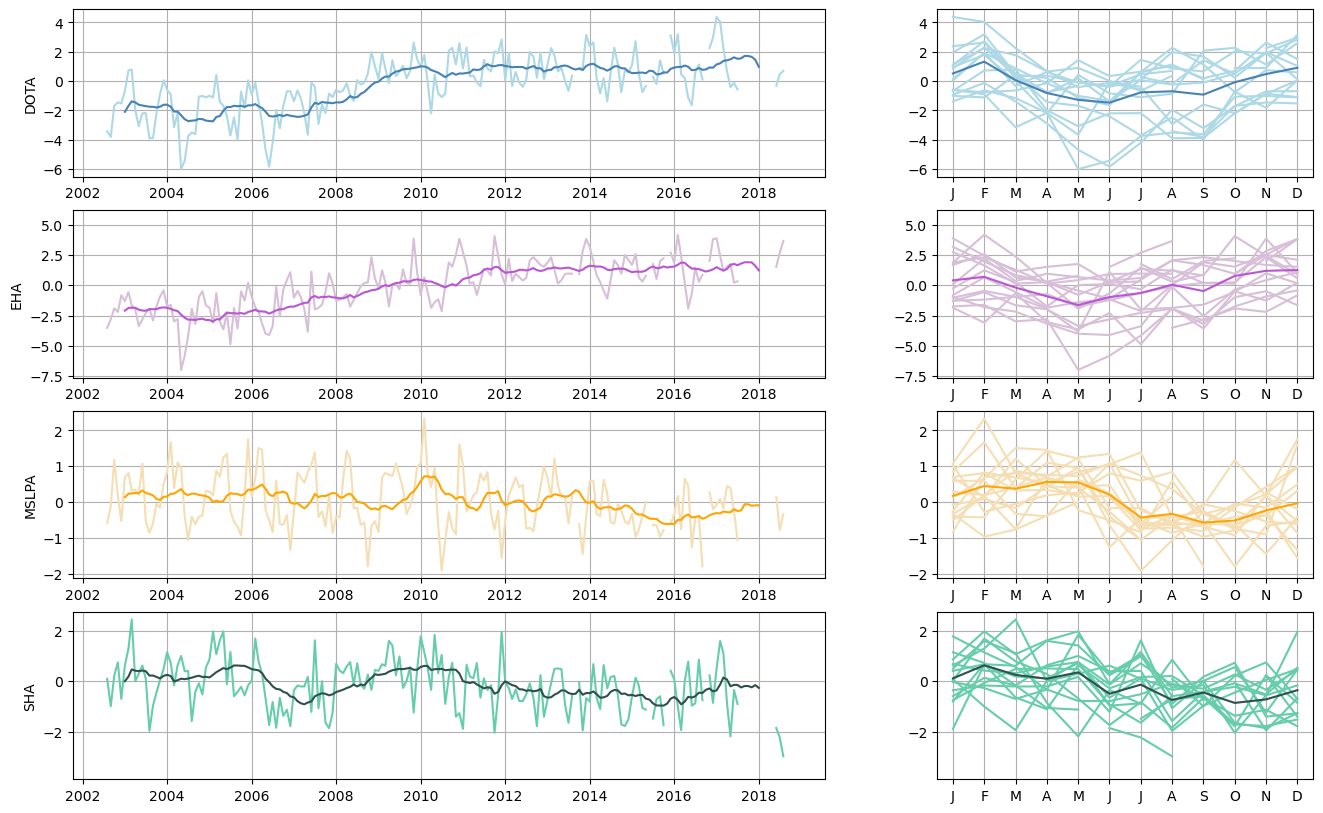

In [21]:
timeseries_with_cmt(atlantic)

(<Figure size 1600x1200 with 10 Axes>,
 array([[<Axes: ylabel='DOTA'>, <Axes: >],
        [<Axes: ylabel='EHA'>, <Axes: >],
        [<Axes: ylabel='MSLPA'>, <Axes: >],
        [<Axes: ylabel='SHA'>, <Axes: >],
        [<Axes: ylabel='GPHA'>, <Axes: >]], dtype=object))

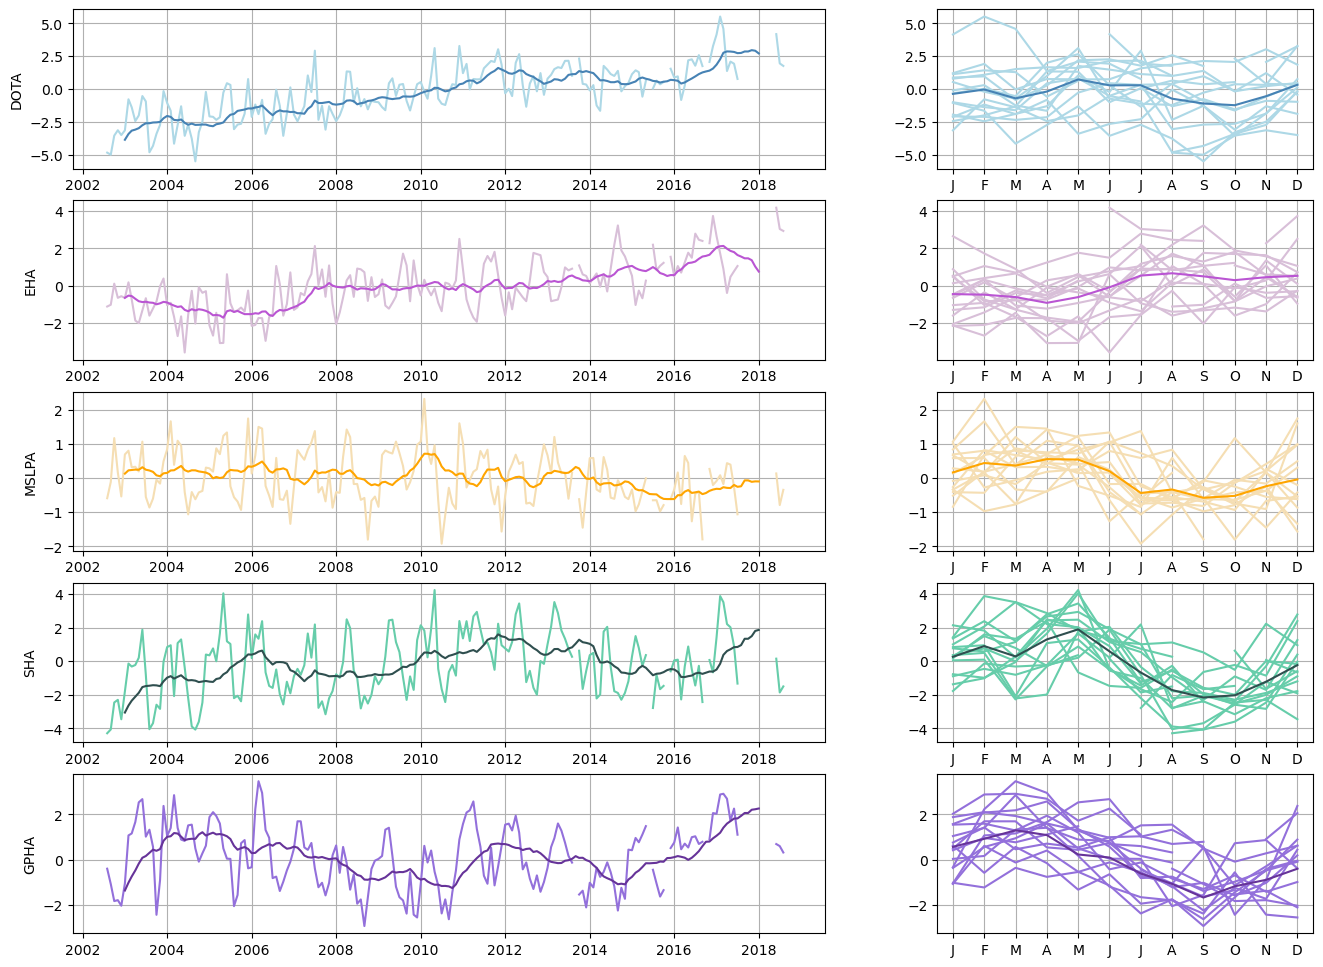

In [48]:
timeseries_with_cmt(peninsula)

(<Figure size 1600x1200 with 10 Axes>,
 array([[<Axes: ylabel='DOTA'>, <Axes: >],
        [<Axes: ylabel='EHA'>, <Axes: >],
        [<Axes: ylabel='MSLPA'>, <Axes: >],
        [<Axes: ylabel='SHA'>, <Axes: >],
        [<Axes: ylabel='GPHA'>, <Axes: >]], dtype=object))

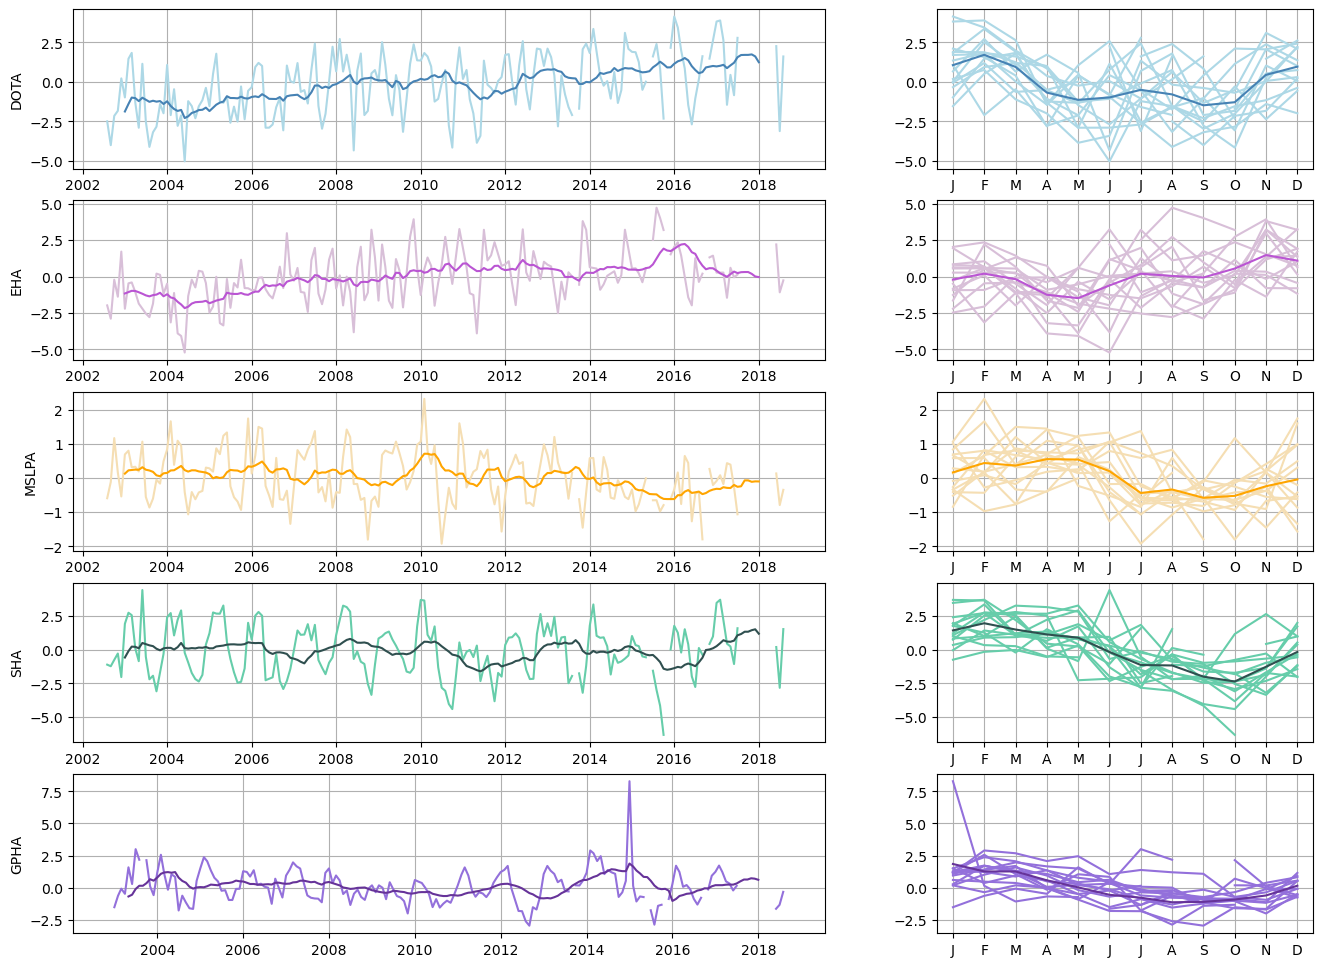

In [49]:
timeseries_with_cmt(australian)

(<Figure size 1600x1200 with 10 Axes>,
 array([[<Axes: ylabel='DOTA'>, <Axes: >],
        [<Axes: ylabel='EHA'>, <Axes: >],
        [<Axes: ylabel='MSLPA'>, <Axes: >],
        [<Axes: ylabel='SHA'>, <Axes: >],
        [<Axes: ylabel='GPHA'>, <Axes: >]], dtype=object))

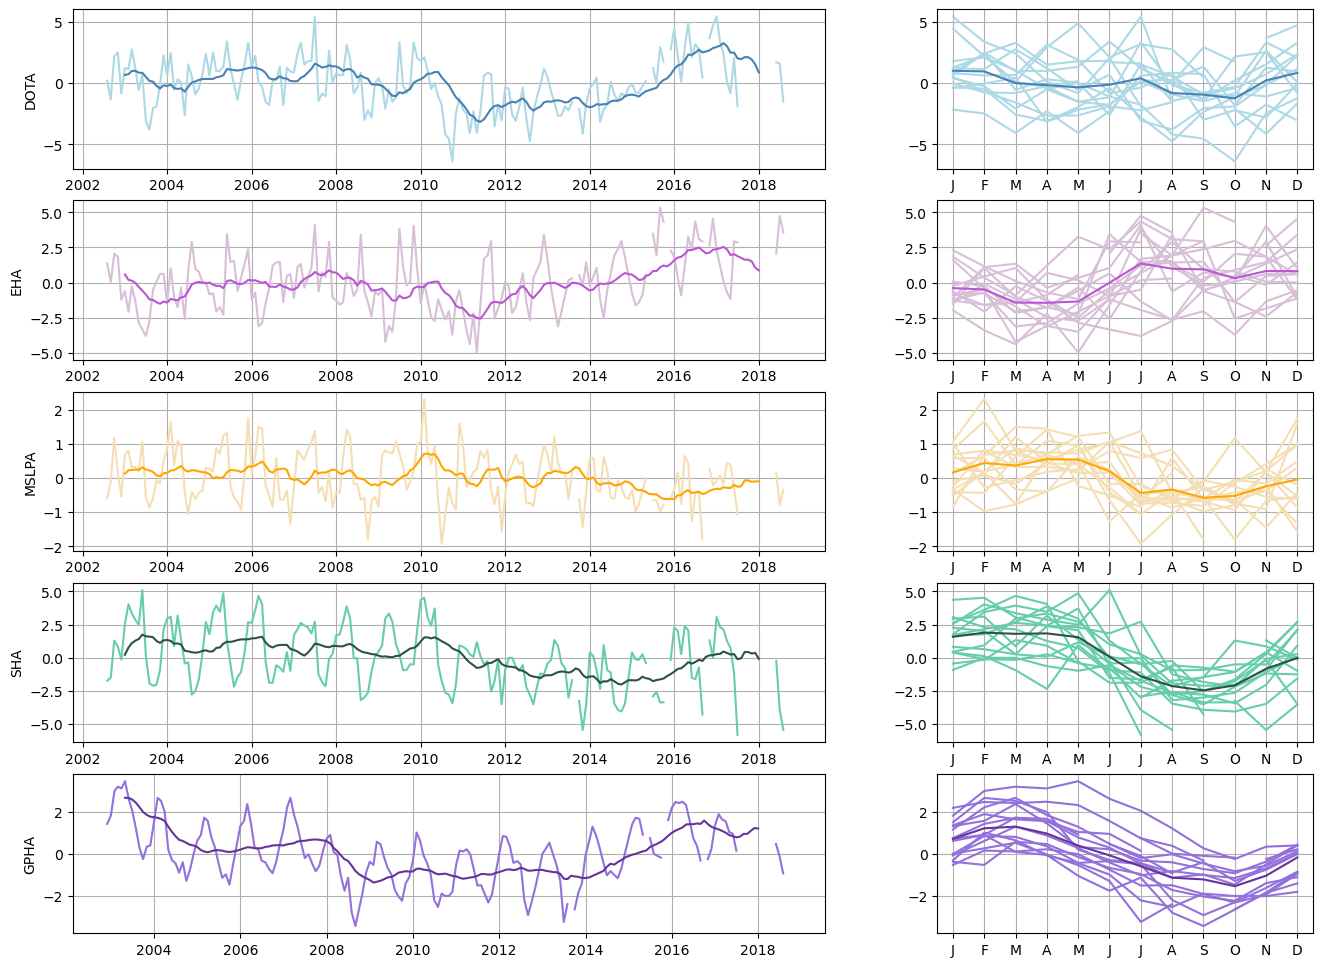

In [51]:
timeseries_with_cmt(pacific)

Interpolating ekevation..


<GeoAxesSubplot: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

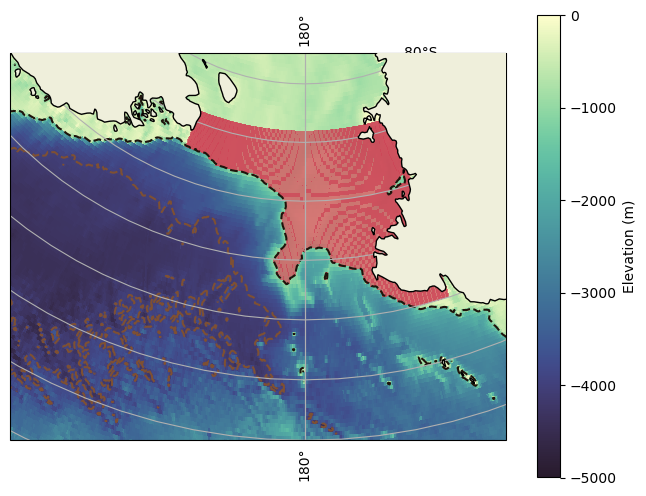

In [6]:
ross_shelf.plot_region(sea='Ross Sea')#extent=[-180,180,-90,-60])

Interpolating ekevation..
Interpolating ekevation..
Interpolating ekevation..


(<Figure size 1600x1000 with 8 Axes>,
 array([[<AxesSubplot: ylabel='DOTA'>, <AxesSubplot: >],
        [<AxesSubplot: ylabel='EHA'>, <AxesSubplot: >],
        [<AxesSubplot: ylabel='SHA'>, <AxesSubplot: >],
        [<AxesSubplot: ylabel='GPHA'>, <AxesSubplot: >]], dtype=object))

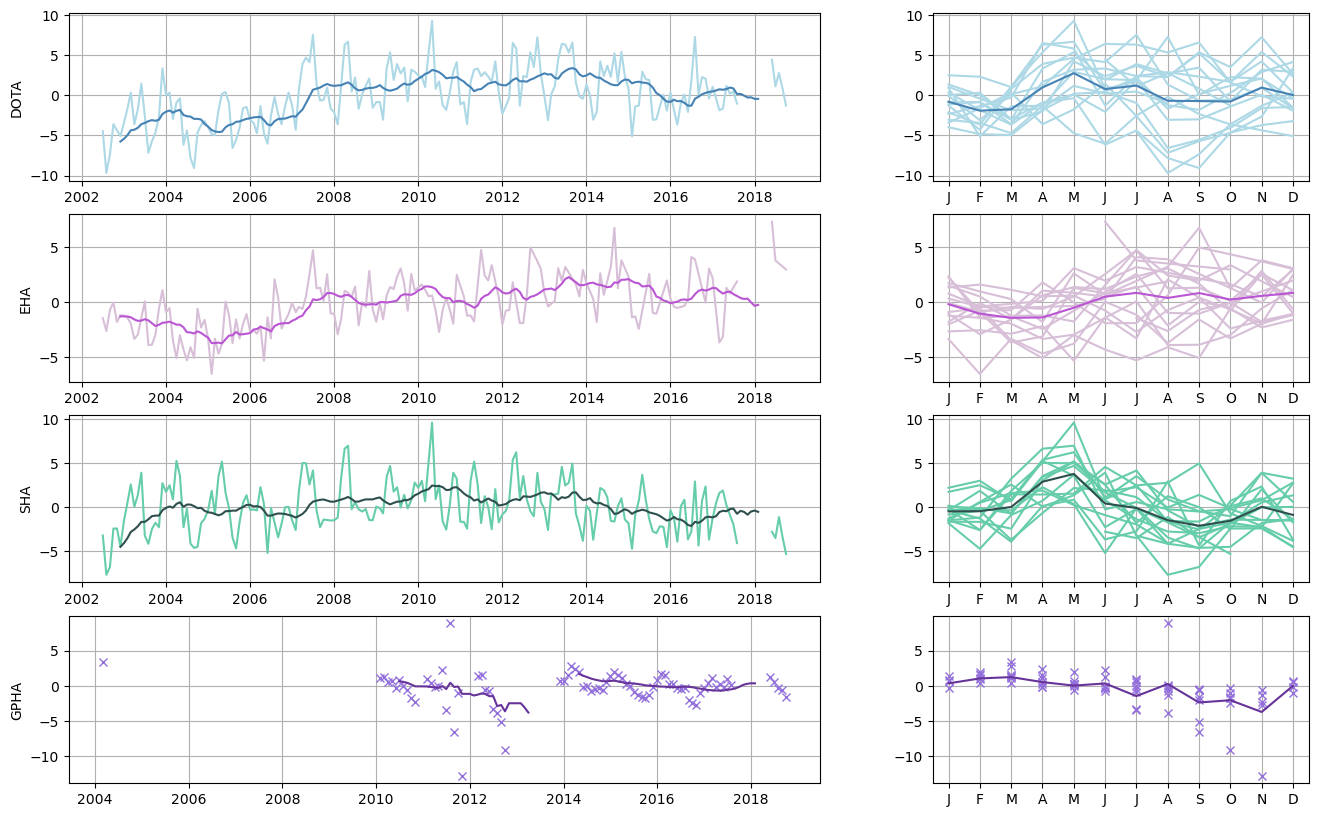

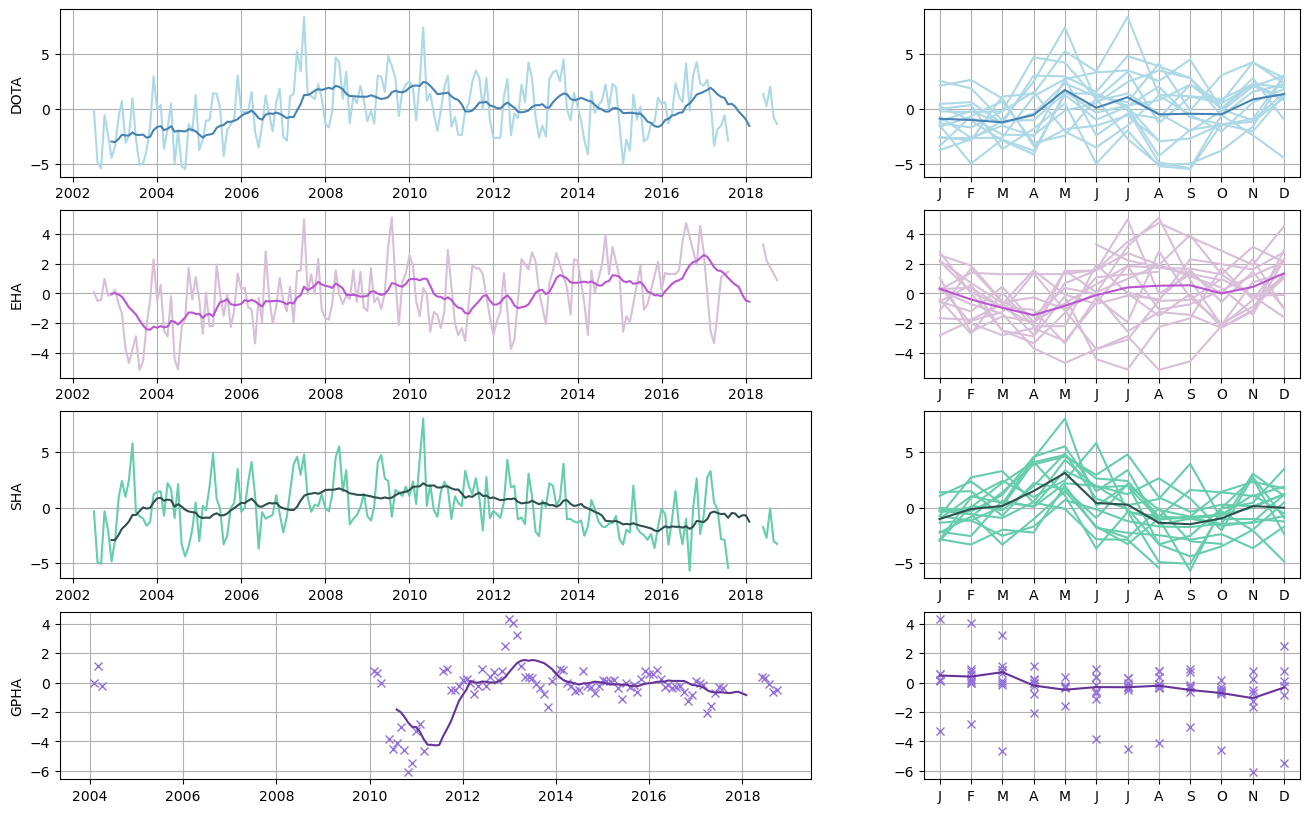

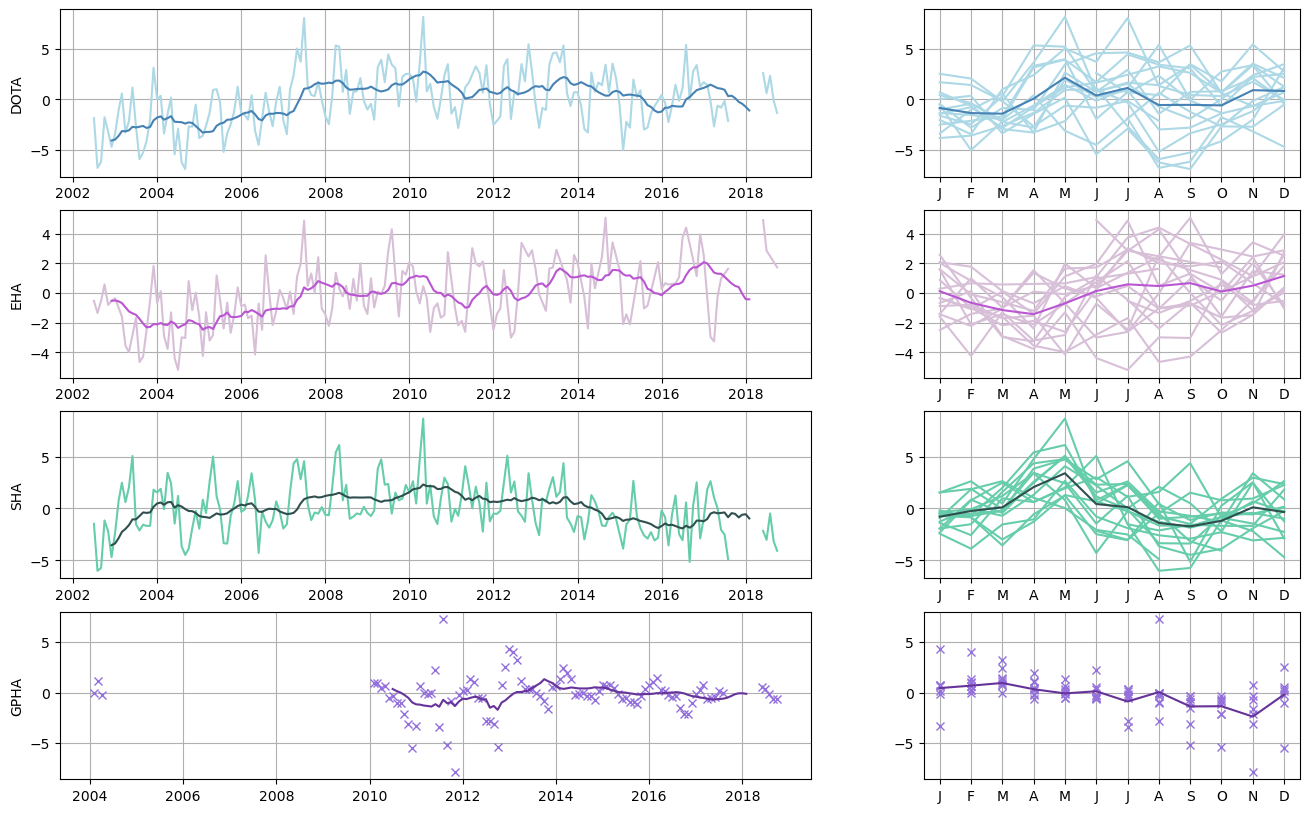

In [299]:
#ross.plot_region()
# f1 = plot_profiles_for_region(ross,markerstyle='x',markersize=6,useall=True)
# f2 = timeseries_bar(ross,annual=False)
# f3 = climatology_bar(ross)
timeseries_with_cmt(ross_shelf)
timeseries_with_cmt(ross_deep)
timeseries_with_cmt(ross_all)

c:\Users\eejco\Anaconda3\envs\sha-env\Lib\site-packages\xarray\core\nputils.py:171: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


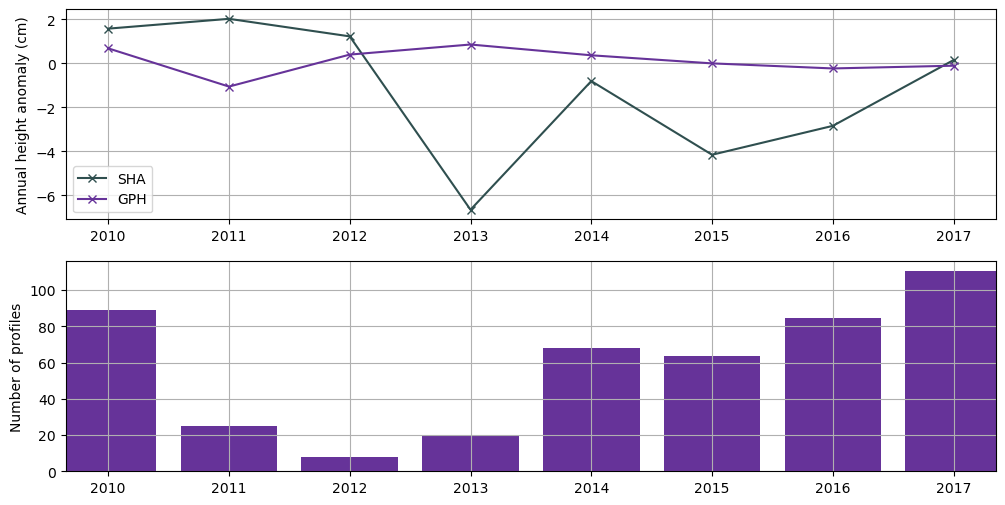

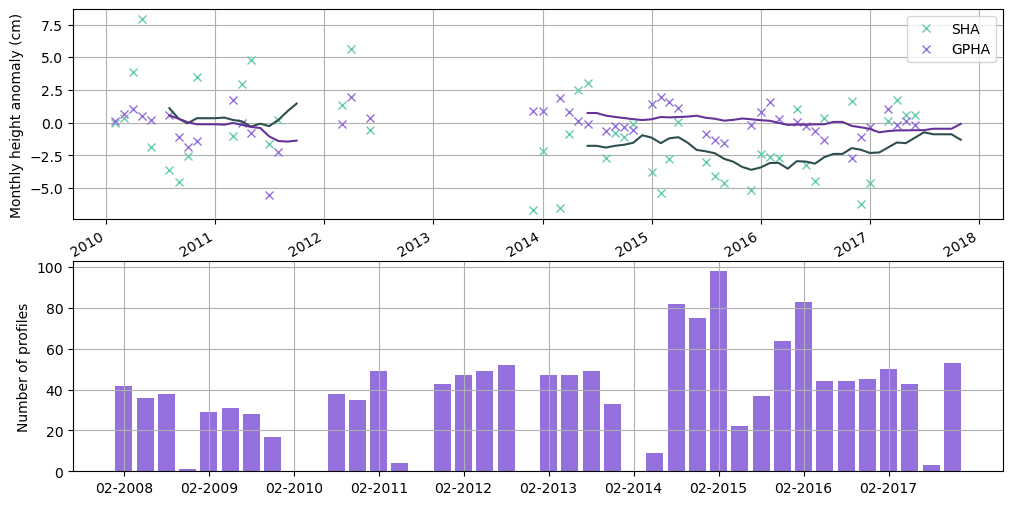

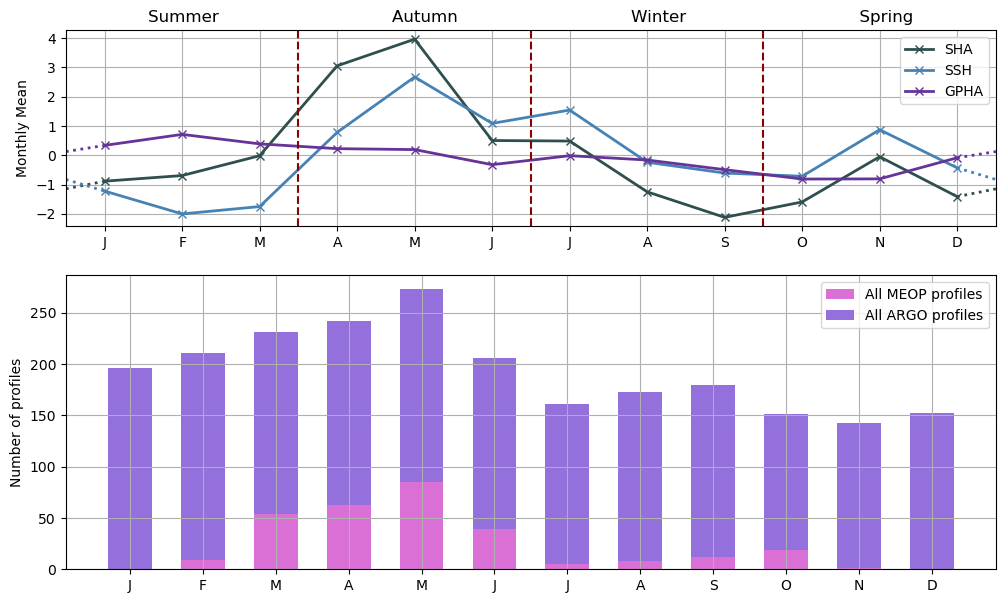

In [31]:
rs = rg("Ross Sea",[170,-150,-85,-70],elevation=gebco_coarse.elevation,min_elevation=-1000)
f2 = timeseries_bar(rs)
f3 = timeseries_bar(rs,annual=False)
f4 = climatology_bar(rs)